# Vorlage | Student Performance Classification

In diesem jupyter notebook werden wir gemeinsam den CRISP-DM Zyklus durcharbeiten, um Ihnen so einen Einblick in die Umsetzung der einzelnen Schritte geben zu können. Als Beispieldatensatz wurde das [Student Performance Data Set](https://archive.ics.uci.edu/ml/datasets/Student+Performance) für sie bereits im Repository im Folder `data/` hinterlegt.

**Inhaltsverzeichnis:**
1. [Business Understanding](#bu)
1. [Data Understanding](#du)
1. [Data Preparation](#dp)
1. [Modeling](#md)
1. [Evaluation](#ev)

## 1. | Business Understanding  <a name="bu"></a>

Dieser Teilschritt unseres Projektes beschäftigt sich mit der Definition eigener Projektziele. Außerdem wird unter anderem der IST-Zustand erhoben & ein detaillierter Projektplan erstellt.

#### Das oberste Ziel unseres Workshops lässt sich wie folgt definieren:
* Erstellen eines automatisierten Systems zur Evaluierung der Performance von SchülerInnen basierend auf den vorliegenden Daten in den Fächern Portugiesisch & Mathematik.
* Unser Modell soll also zwischen jenen SchülerInnen unterscheiden können, die eine positive bzw. negative Abschlussnote bekommen haben.

#### Zum Erreichen dieses Zieles müssen folgende Unterziele erfüllt werden:
* Explorative Datenanalyse, die uns einen Einblick in die Beschaffenheit der Daten gewährt.
* Vorverabeitung der Daten, sodass sie für die Verarbeitung in Machine Learning Algorithmen geeignet sind.
* Herausarbeiten eigener Features, die wir als ausschlaggebend für das Abschneiden der SchülerInnen identifizieren (Feature Engineering).
* Modellieren einer einfachen Baseline (Support Vector Machine), die uns die Evaluierung unseres (komplexeren) Machine Learning Modells ermöglicht.
* Aufbau eines neuronalen Netzes, das für die binäre Klassifizierung (0 - failed, 1 - passed) des SchülerInnenerfolges geeignet ist.
* Evaluieren des Trainingsfortschritts (Loss-curves) unseres neuronalen Netzes.
* Evaluieren der Performance der binären Klassifizierung mittels `confusion_matrix`, `accuracy_score` & `classification_report`.

#### Weitere persönliche Ziele?
* ...


## Code | Import statements & vordefinierte Funktionen
Dieser Bereich ist für das Hereinladen aller benötigten Module und Funktionen bestehender Bibliotheken, sowie für das Definieren eigener Funktionen gedacht.

In [1]:
# We start by importing all necessary modules and functions we need for our project.
import os
import itertools
from datetime import datetime

import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm as matplotlib_cm, rc_file_defaults
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import Callback, EarlyStopping, TensorBoard

In [2]:
# You may want to use this function when evaluating your model's performance.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='Blues'):
    """ Plot Confusion Matrix.
    
    Parameters
    ----------
    cm : confusion matrix
        may be generated by using sklearn's confusion_matrix function
        see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html for details
    classes : array-like of shape (n_classes,)
         Target names used for plotting.
    normalize : boolean, default=False
         Controls normalization of confusion matrix. Set to True if you want to display percentages in your confusion matrix.
    cmap : str or matplotlib Colormap, default='Blues'
        Colormap recognized by matplotlib.
    """
    
    fig = plt.figure(figsize=(5, 5))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3, out=None)  
    
    
    thresh = cm.max() / 2.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# code adapted from https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface
# to help you understand what an SVM does in two dimensions by visualisizing it's decision boundary
# important: scale x_feature and y_feature to be within [0, 1] for this function to work properly
def plot_svm_decision_boundary(x_feature,
                               y_feature,
                               y_true,
                               clf,
                               cmap='Blues',
                               x_label='Grade in first Trimester',
                               y_label='Grade in second Trimester',
                               title='Decision surface of linear SVC',
                               scatter_labels=['True Label: Failed', 'True Label: Passed']):
    color_map = matplotlib_cm.get_cmap(cmap)
    fig, ax = plt.subplots(figsize=(8,8))
    xx, yy = make_meshgrid(x_feature, y_feature, h=.0005)
    plot_contours(ax, clf, xx, yy, cmap=color_map, alpha=0.75)

    #plot negatives:
    ax.scatter(x_feature[y_true[y_true==0].index],
               y_feature[y_true[y_true==0].index],
               color=color_map(0), cmap=color_map, s=25, edgecolors='k', label=scatter_labels[0])
    # plot positives:
    ax.scatter(x_feature[y_true[y_true==1].index],
               y_feature[y_true[y_true==1].index],
               color=color_map(255), cmap=color_map, s=25, edgecolors='k', label=scatter_labels[1])

    ax.legend()
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_xticks(np.arange(0, 1.1, step=0.1))
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.set_title(title)
    plt.show()
    
    
#helper functions to declutter plot_svm_decision_boundary 
def make_meshgrid(x, y, h=.02):
    x_min, x_max = 0 - 0.1, 1 + 0.1
    y_min, y_max = 0 - 0.1, 1 + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [4]:
# Anlegen der notwendigen Folder für logs & model files die zum Training des neuronalen Netzes notwendig sind

logdir = "logs/"
modeldir = "models/"

if not os.path.exists(logdir):
    os.makedirs(logdir)

if not os.path.exists(modeldir):
    os.makedirs(modeldir)

## 2. | Data Understanding  <a name="du"></a>
Üblicherweise beginnt dieser Teil des Zyklus mit dem Sammeln und Beschreiben der Daten, die zu untersuchen sind. Da im Workshop jedoch ein Beispieldatensatz zur Verfügung gestellt wird, können wir uns auf das Wesentliche konzentrieren: das Verstehen der Daten.

Als Hilfestellung sei die Quelle des Datensatzes genannt:
* P. Cortez and A. Silva. [Using Data Mining to Predict Secondary School Student Performance](http://www3.dsi.uminho.pt/pcortez/student.pdf). In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.

Außerdem folgt die Beschreibung der einzelnen Attribute im der nächsten Zelle dieses jupyter notebooks:

In [5]:
# # Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
# 1 school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
# 2 sex - student's sex (binary: "F" - female or "M" - male)
# 3 age - student's age (numeric: from 15 to 22)
# 4 address - student's home address type (binary: "U" - urban or "R" - rural)
# 5 famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
# 6 Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
# 7 Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
# 8 Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
# 9 Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
# 10 Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
# 11 reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
# 12 guardian - student's guardian (nominal: "mother", "father" or "other")
# 13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
# 14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
# 15 failures - number of past class failures (numeric: n if 1<=n<3, else 4)
# 16 schoolsup - extra educational support (binary: yes or no)
# 17 famsup - family educational support (binary: yes or no)
# 18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
# 19 activities - extra-curricular activities (binary: yes or no)
# 20 nursery - attended nursery school (binary: yes or no)
# 21 higher - wants to take higher education (binary: yes or no)
# 22 internet - Internet access at home (binary: yes or no)
# 23 romantic - with a romantic relationship (binary: yes or no)
# 24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
# 25 freetime - free time after school (numeric: from 1 - very low to 5 - very high)
# 26 goout - going out with friends (numeric: from 1 - very low to 5 - very high)
# 27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
# 28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
# 29 health - current health status (numeric: from 1 - very bad to 5 - very good)
# 30 absences - number of school absences (numeric: from 0 to 93)

# # these grades are related with the course subject, Math or Portuguese:
# 31 G1 - first period grade (numeric: from 0 to 20)  -> corresponds to the first trimester
# 31 G2 - second period grade (numeric: from 0 to 20) -> corresponds to the second trimester
# 32 G3 - final grade (numeric: from 0 to 20, output target)

# Additional note: there are several (382) students that belong to both datasets . 
# These students can be identified by searching for identical attributes
# that characterize each student, as shown in the annexed R file.

### 2.1 | Das Einlesen der Daten 
Das Einlesen der vorbereiteten CSV-Files in DataFrames erledigen wir über die `read_csv()` Funktion der Bibliothek [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/).

In [6]:
# loads in the CSV file containing grades in subject portuguese.
df_por = pd.read_csv('data/student-por.csv', sep=';')
# loads in the CSV file containing grades in subject maths.
df_mat = pd.read_csv('data/student-mat.csv', sep=';')

In [7]:
df_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [8]:
df_mat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### 2.2 | Erste Analysen

Beantworten Sie folgende Fragen:

* Wieviele SchülerInnen sind in den einzelnen Datensätzen aufgezeichnet?
* Sind die Datensätze vollständig, oder befinden sich fehlende Werte darin?
* Wieviele Spalten enthalten nicht-numerische Werte, die für eine weitere Verarbeitung präprozessiert werden müssen?
    * Die Behandlung nicht-numerischer Werte wird nachgelagert in der Phase [Data Preparation](#dp) erledigt.

In [9]:
# TODO: answer the questions above!

### 2.3 | Visualisierungen <a name="vi"></a>

Histogramme, Boxplots und andere grafische Darstellungsmöglichkeiten sind ein unerlässliches Werkzeug in der Analyse tabellarischer Daten.
Da wir mit pandas arbeiten, eignet sich die Bibliothek [seaborn](https://seaborn.pydata.org/index.html) bestens, um solche Visualisierungen zu erstellen.

<strong>Disclaimer</strong>: Im für sie bereitgestellten Docker Container ist seaborn in der Version 0.10.1 vorinstalliert. Sollten Sie den vollen Umfang der Version 0.11, der auch in der aktuellen [Dokumentation](https://seaborn.pydata.org/api.html) zu seaborn verwendet wird, nutzen wollen, führen Sie bitte die folgende Zelle im Notebook aus und starten Sie den Kernel des Notebooks neu.

In [10]:
%pip install seaborn -U

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.8/site-packages (0.11.0)
Note: you may need to restart the kernel to use updated packages.


In [11]:
sns.__version__

'0.11.0'

Entwickeln Sie anhand der folgenden Beispiele eigene Analysen, indem Sie mit den einzelnen Spalten des Datensatzes experimentieren.

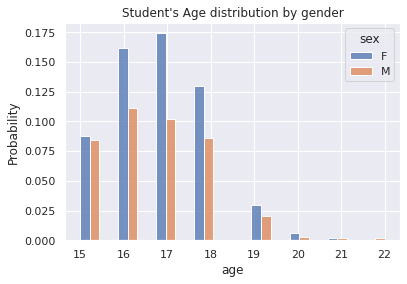

In [12]:
sns.set_theme(style="darkgrid")
sns.histplot(x="age", hue="sex", data=df_por, multiple='dodge', stat='probability')
plt.title('Student\'s Age distribution by gender')
plt.show()

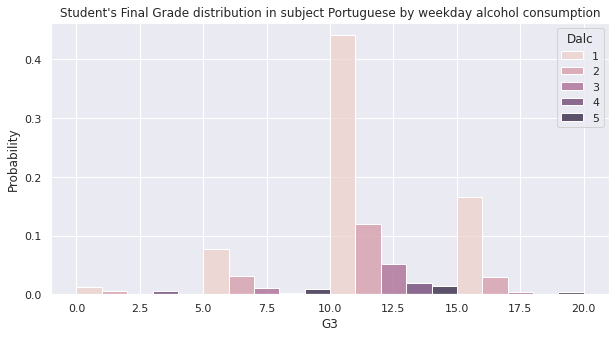

In [13]:
plt.figure(figsize=(10,5))
sns.set_theme(style="darkgrid")
sns.histplot(x="G3", hue="Dalc", data=df_por, multiple='dodge', stat='probability', binwidth=5)
plt.title('Student\'s Final Grade distribution in subject Portuguese by weekday alcohol consumption')
plt.show()

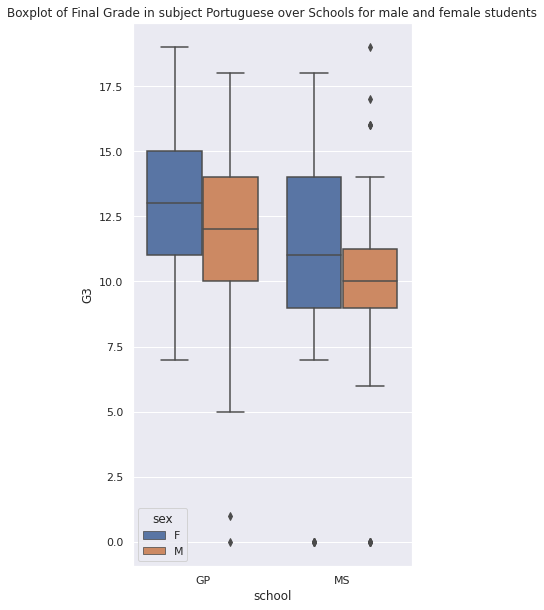

In [14]:
plt.figure(figsize=(5,10))
sns.set_theme(style="darkgrid")
sns.boxplot(x="school", y="G3", hue='sex', data=df_por)
plt.title('Boxplot of Final Grade in subject Portuguese over Schools for male and female students')
plt.show()

In [15]:
#Todo: Analyse the data on your own using the visualisation tools provided!

Fühlen Sie sich gerüstet, um in die Phase der Data Preparation überzugehen?

Um dies beurteilen zu können, sollten Sie in der Lage sein, folgende Fragen zu beantworten:
* Ist die Datenqualität ausreichend, um weiterführende Analysen zu ermöglichen?
    * Denken Sie dabei an die Stichworte:
        * Vollständigkeit
        * Richtigkeit
        * Sauberkeit
* Können die von uns festgelegten Ziele in der Phase des [Business Understandings](#bu) mit den vorliegenden Daten erreicht werden?

## 3. | Data Preparation  <a name="dp"></a>
In dieser Phase werden wir uns um die Vorverarbeitung der Daten kümmern. Typische Schritte enthalten das Auswählen, Säubern, Aggregieren und Formatieren von Daten. Der Schritt des Data Cleanings wurde bereits für uns erledigt, somit ist kein weiteres Säubern der Daten notwendig.


### 3.1 | Aggregieren

Nun, da Sie grundlegend mit den Daten vertraut sind, verbinden wir die beiden Datensätze, um so einen größeren (diverseren) Datensatz für unsere Modelle zu erhalten.
* Fügen Sie jedem der beiden DataFrames eine neue Spalte hinzu, der das aufgezeichnete Schulfach enthält.
* Kombinieren Sie die beiden DataFrames zu einem einzigen DataFrame `df`.

In [ ]:
# TODO: add a column to your dataframes holding the subject represented within (e.g. 'maths' and 'portuguese')
#       combine the two dfs

### 3.2 | Formatieren

Nach dem Aggregieren der beiden Datensätze, kümmern wir uns nun darum, all jene Spalten zu behandeln, die nicht-numerische Werte beinhalten.

* Analysieren sie den DataFrame noch einmal, und geben Sie aus, welche Spalten in numerische Werte zu konvertieren sind.
* Überlegen Sie sich eine Strategie zur Codierung kategorischer Werte sowie binärer Werte.
    * Beachten Sie dabei auch die Codierung bereits bestehender numerischer Werte!

In [ ]:
#TODO: find a way to format your non-numerical data.
# the pandas Categorical class
# see: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html
# should give you a hint on one (easy) way to do this.

### 3.3 | Feature Engineering

Ein weiterer Schritt der Datenvorverarbeitung ist das Vorselektieren aussagekräftiger Datenmerkmale (engl. Features) bzw.  Spalten, die an die Machine Learning Modellen weitergegeben werden. Im Konkreten ist eine Dimensionsreduktion der bestehenden Daten vorzunehmen. Diese Aufgabe kann basierend auf den Analysen aus Schritt [2.2 | Visualisierungen](#vi) und ihrem Domänenwissen geschehen, oder aber (für die fortgeschritteneren User) auf Basis von Algorithmen wie der [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) übernommen werden.


Ein hilfreiches Instrument zur Analyse der Aussagekraft einzelner Features ist die Korrelationsanalyse, also die Analyse des Zusammenhangs der einzelnen Spalten in Ihren Daten. Auch eine spaltenweise Analyse der Daten per Boxplot kann Ihnen zusätzliche Informationen zur Relevanz einzelner Features geben. 

In [ ]:
# plot the pairwise correlation coefficients of your data set using the DataFrame's corr() Method
# see: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
corr = df.corr()
sns.set(font_scale=3)
plt.figure(figsize=(100,100))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap='Blues')
sns.despine(offset=10, trim=True)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light' 
);

In [ ]:
#plot a boxplot for each column using seaborn.
plt.figure(figsize=(40,20))
sns.set(font_scale=3)
sns.boxplot(data=df)
sns.despine(offset=0,
            trim=True)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light' 
);

Typischerweise wird die Aufgabe des Feature Engineerings in Iterationen erledigt, in denen man die Anzahl der gewählten Features schrittweise einschränkt, ein Machine Learning Modell mit den gewählten Features trainiert, um so mehrere Konfigurationen ausprobieren zu können.

Abschließend ist nicht zu vergessen, den Zielwert (engl. target oder label) für unsere Machine Learning Modelle festzulegen. Im präsentierten Beispielfall ist eine <strong>binäre Klassifikation</strong> der Gesamtnoten der SchülerInnen vorzunehmen (`df['G3']`). Da die Notenskala jedoch zwischen 0 und 20 definiert ist, ist die Extraktion & Transformation des Zielwerts aus dem Datenset ein Teil der Datenvorverarbeitung.

<strong>Achtung:</strong> Jene Spalte, die von unserem Machine Learning Modell auf Basis der Features vorausgesagt werden soll, darf natürlich <strong>nicht</strong> Teil der Features sein!

In [ ]:
#TODO: select a subsample of the avalaible columns from the dataframe that you deem to be relevant for the binary classification task
# return to this task and after modeling your machine learning models,
# and increase/decrease the number of features selected to improve your model's performance
# save the subsampled data to a DataFrame (or 2D-Array) 'X'
# make sure to exclude column 'G3' from 'X'!

X = ...

In [ ]:
#TODO: extract the column 'G3' from the dataset and save it to a 1D array or pandas.Series 'y'
# be sure to transform this series from its original values to:
#       1 where a student scored G3>=10
#       0 everywhere else
# This makes sure to prepare or labels for the binary classification task.

y = ...

### 3.4 | Skalieren

Eine weitere typische Aufgabe im Kontext der Datenvorverarbeitung stellt das Skalieren der Daten dar. Diese Skalierung soll dabei helfen, die numerische "Wichtigkeit" der Werte einzelner Spalten im Vergleich zu anderen Spalten zu behalten.
Auch hier gibt es mehrere Möglichkeiten dies vorzunehmen, eine (spaltenweise) Skalierung aller Werte zwischen \[0, 1\] ist ein erster, simpler Ansatz, der hier anzudenken ist.

In [ ]:
#TODO: scale your selected features by column to be in the interval [0, 1]
# an easy way to do this is using sklearn's MinMaxScaler
# see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#
# or you can also do it manually :)

## 4. | Modeling  <a name="md"></a>
In der Phase des Modellierens werden die nun vorbereiteten Features zum Trainieren von Machine Learning Modellen verwendet. Dazu müssen aber erst einige Voraussetzungen erfüllt sein, bevor das Training beginnen kann. Zur Evaluierung der Modelle ist es notwendig, das bestehende Datenset in drei separate Datensätze aufzuteilen.



### 4.1 | Training, Testen & Validieren
Disclaimer: Die hier nachfolgenden direkten Zitate sind dem Buch ["Deep Learning", Goodfellow et al., 2016; Section 5.3](https://www.deeplearningbook.org/contents/ml.html) entnommen.

"We discussed how a held-out test set, composed of examples coming from the same distribution as the training set, can be used to estimate the generalization error of a learner, after the learning process has completed."

"It is important that the test examples <strong>are not used in any way to make choices about the model</strong>, including its hyperparameters."

Worauf uns Goodfellow et al. hiermit hinweisen wollen, ist die Aufteilung unseres Datensatzes in ein <strong>Trainingsset</strong> sowie ein <strong>Testset</strong>. Wichtig dabei ist, dass Trainings-, bzw. Testset jeweils aus Datenpunkten (`X`) sowie den dazugehörigen Labels (`y`) bestehen. Das <strong>Trainingsset</strong> wird zum Optimieren der Hyperparameter des Modells verwendet, wohingegen das <strong>Testset</strong> zur Trainingszeit vollkommen unberührt bleibt. Üblicherweise übernimmt die `sklearn` Funktion [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) diese Aufgabe für uns.

<center><img src="images/train_test_val_split.png" style="width: 50%;"/></center>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None, stratify=y)

Aufgrunddessen, dass das Testset vom Trainingsprozess völlig ausgeschlossen wird, wird ein weiteres Datenset benötigt, das zur Evaluierung der Modellperformance während der Trainingszeit verwendet wird.

"In order to create a subset of the data, which will help us tune the hyperparameters of the model, we need to <strong>split the training set into a training and validation set.</strong>"

Wie ein solches Aufteilen des Trainingssets in Trainings-, und Validierungsdaten aussieht, wird beim Trainieren des neuronalen Netzes genauer behandelt.

### 4.1a | Definition und Evaluierung einer Baseline
Vor dem Definieren und Trainieren komplexer Machine Learning Modelle ist es anzuraten, einfachere Ansätze, wie [Naive Bayes Classifier](https://www.cc.gatech.edu/~isbell/reading/papers/Rish.pdf) oder [Support Vector Machines (SVMs)](https://www.kdnuggets.com/2016/07/guyon-data-mining-history-svm-support-vector-machines.html) auf die Problemstellung anzuwenden um eine erste Einschätzung der zu erwartenden Modellperformance zu bekommen.

Im gegenständlichen Fall haben wir uns für die Anwendung einer linearen SVM entschieden, die uns in `sklearn` als [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) bereitgestellt wird.
Das Ausführen der Methode `fit()` startet dabei bereits den Trainingsprozess der SVM, wobei für ein erfolgreiches Training die Datenpunkte des Trainingssets (`X_train`) sowie die dazugehörigen Labels (`y_train`) übergeben werden müssen.

In [ ]:
svm = LinearSVC()
svm.fit(X_train, y_train)

Ohne auf die genaue Funktionalität einer SVM eingehen zu wollen, sei gesagt, dass eine SVM vereinfacht gesagt darauf optimiert wird, eine Entscheidungsgrenze (engl. decision boundary) zwischen die Datenpunkte der einzelnen Klassen des Trainingssets zu legen. Eine visuelle Darstellung der Funktionsweise im zweidimensionalen Raum entnehmen Sie bitte folgender Grafik, adaptiert auf Basis dieses [Blogs](http://blog.pengyifan.com/tikz-example-svm-trained-with-samples-from-two-classes/):

<center><img src="images/svm.png" style="width: 50%;"/></center>

Die definierte Baseline gilt es nun zu evaluieren, und zwar mit jenen Daten, die aus dem Trainingsprozess herausgehalten worden sind: dem <strong>Testset</strong> bestehend aus den Datenpunkten des Testsets (`X_test`) sowie den dazugehörigen Labels (`y_test`).
Das Testen beginnt mit dem Aufruf der Methode `predict()` der trainierten SVM (`svm`) welcher `X_test` übergeben wird.

In [ ]:
y_pred = svm.predict(X_test)

Der Rückgabewert dieser Funktion enthält jene Labels, die der Klassifizierungsalgorithmus für die einzelnen Datenpunkte vorhergesagt hat. Eine Gegenüberstellung der wahren Labels für die Datenpunkte des Testsets (`y_test`) zu den prädizierten Werten (`y_pred`), gibt nun Auskunft darüber, wie gut der Klassifizierungsalgorithmus zwischen Datenpunkten einer ungesehen Population unterscheiden gelernt hat.

Diese Gegenüberstellung wird üblicherweise durch die Funktionen `confusion_matrix`, `accuracy_score` oder `classification_report` des Packages `sklearn` übernommen. Verwenden Sie auch die eigens hierfür definierte Funktion `plot_confusion_matrix` um die confusion matrix (dt. Wahrheitsmatrix oder Konfusionsmatrix) übersichtlich anzuzeigen.

In [ ]:
cm = confusion_matrix(y_test, y_pred)

rc_file_defaults()
plot_confusion_matrix(cm,
                      classes=['Failed', 'Passed'],
                      normalize=True)

In [ ]:
print("This results in an accuracy score of {:.2f}".format(accuracy_score(y_test, y_pred)))

In [16]:
print(classification_report(y_test, y_pred))

NameError: name 'y_test' is not defined

Nach einer ersten Evaluierung ihrer Baseline ist es nun an der Zeit, ihr erstes komplexes Machine Learning Modell zu trainieren!
Da ein Deep-Dive in die Funktionsweise neuronaler Netze den heutigen Rahmen sprengen würde, sei uns jedoch zuvor ein kurzer Exkurs in die Darstellung der Entscheidungsgrenze einer SVM erlaubt, die auf das gegenständliche binäre Klassifizierungsproblem optimiert wurde.

### 4.1b | Exkurs: Visualisierung der Entscheidungsgrenze einer linearen SVM

Obwohl SVMs auch Entscheidungsgrenzen in hochdimensionalen Räumen finden können, reicht die Vorstellungskraft des menschlichen Geistes für solch abstrakte Konstrukte jedoch nicht aus. Etwas Abhilfe soll folgendes Experiment liefern, das ihnen die Funktionalität einer SVM anhand eines Praxisbeispiels näherbringen möchte.

Beschränkt man sich in der Wahl der Features auf zwei Dimensionen (im Beispiel wurden die beiden aussagekräftigten Features `'G1'`und `'G2'` gewählt), ist es möglich, die aus dem Trainingsprozess resultierende Entscheidungsgrenze visuell darzustellen:

In [ ]:
X_svm = df[['G1', 'G2']]

X_svm = X_svm.apply(lambda column: column/column.max(), axis=0)

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm,
                                                                    y,
                                                                    test_size=0.33,
                                                                    random_state=None,
                                                                    stratify=y)

svm = LinearSVC()
svm.fit(X_train_svm, y_train_svm)

rc_file_defaults()
plot_svm_decision_boundary(x_feature=X_test_svm['G1'],
                           y_feature=X_test_svm['G2'],
                           y_true=y_test_svm,
                           clf=svm)
plt.show()

### 4.2 | Definition eines neuronalen Netzes

Im nächsten Teil der Modellierungsphase beschäftigen wir uns mit dem Definieren eines neuronalen Netzes wie es in [Keras](https://keras.io/) vorgenommen wird. Wichtig dabei ist, dass gerade in diesem Schritt technische Details, mathematisches Wissen und Erfahrung in der Optimierung der Netzarchitektur nötig sind, um ein funktionsfähiges neuronales Netz für den gegebenen Anwendungsfall erstellen zu können.

Für unseren einfachen Fall der binären Klassifizierung wäre folgende Struktur denkbar:

In [ ]:
n_features = X_train.shape[1]


model = Sequential(name='binary_classification')
model.add(Input(shape=(n_features,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

loss_function = "binary_crossentropy"
optimizer = "adam"

model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=["accuracy"])

Eine Zusammenfassung der Architektur des Netzes, der darin enthaltenen Schichten und ihrer Hyperparameter gibt die Funktion `model.summary()` aus.

In [ ]:
model.summary()

Das Starten des Trainingsprozesses beginnt auch in diesem Fall mit dem Aufruf der `fit()` Methode des Modells. Zu beachten ist hierbei, dass im Falle eines neuronalen Netzes nun das weitere Aufteilen des Trainingsset in ein <strong>Trainingsset</strong> und <strong>Validierungsset</strong> für die Evaluierung des Trainingsprozesses zur Laufzeit nötig ist. Diese Aufteilung kann über den Parameter `validation_split` der `fit()` Methode gesteuert werden.

In [ ]:
tb = TensorBoard(log_dir=logdir + "Binary_classification_students_" + datetime.now().strftime("%Y.%m.%d-%H:%M:%S"))
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.005,
                           patience=10,
                           mode='auto') 
model.fit(X_train, y_train,
        validation_split=0.33,
        verbose=1,
        callbacks=[early_stop, tb],
        epochs=150)

### 4.3a | Evaluieren des Trainingsprozesses

Ein wichtiger Teil der Modellierungsphase, die nach dem Training eines Modelles erfolgt, ist die Evaluierung des Trainingsprozesses. Während des Trainings versucht unser neuronales Netz, den entstehenden Fehler bei der binären Klassifizierung der Abschlussnote unserer SchülerInnen zu minimieren. Um zu verhindern, dass dabei allerdings die Trainingsdaten einfach "auswendig gelernt" werden, sollte das Training vorzeitig abgebrochen werden, wenn der Fehler gemessen an den Validierungsdaten, größer wird.


Eine visuelle Evaluierung des Trainingsprozesses erfolgt meist über das Auswerten sogenannter Lernkurven (engl. learning curves oder loss curves). Diese Kurven zeigen den Verlauf des Fehlers gemessen an Trainings-, und Validierungsdaten über die Trainingsepochen.

Sobald Sie ein neuronales Netz trainiert haben, können Sie innerhalb ihres Docker Containers in jenes Verzeichnis wechseln, das den `logs/`Folder enthält (bspw. `/notebooks/py-data-science-basics/`) und dort den Befehl

``
tensorboard --logdir logs --host 0.0.0.0
``

starten. Navigieren Sie nun in Ihrem Browser auf http://localhost:6006, um die Lernkurven inspizieren zu können.

### 4.3b | Bias & Variance, Overfitting & Underfitting

Um die Lernkurven ihres trainierten Modells evaluieren zu können, sollten sie mit den oben genannten Begriffen vertraut sein.
Einen einfachen Startpunkt für ihre Recherche zu Bias & Variance bietet dieser Artikel auf [medium.com](https://medium.com/@akgone38/what-the-heck-bias-variance-tradeoff-is-fe4681c0e71b).


Mit dem Wissen des Artikels ausgestattet, lassen sich die Begriffe Overfitting & Underfitting anhand der folgenden Grafik erklären:

<center><img src="images/overfitting_underfitting.png" style="width: 70%"/></center>

<center><a href="https://www.deeplearningbook.org/">"Deep Learning", Goodfellow et al., 2016; Section 5.2</a></center>


- "**Underfitting** occurs when the model is not able to obtain a sufficiently low error value on the training set."

- "**Overﬁtting** occurs when the gap between the training error and validation error is too large."

Zum Abschluss möchte ich Ihnen Andrew Ng's [Video zum Thema Learning Curves](https://www.youtube.com/watch?v=ISBGFY-gBug) ans Herz legen.

Wenn Sie mit dem Trainingsverlauf ihres neuronalen Netzes zufrieden sind, können Sie nun zum letzten Schritt übergehen: Dem Evaluieren ihres neuronalen Netzes auf Basis des <strong>Testdatensets</strong>, dem unberührten Teil der Daten.

## 5. | Evaluation  <a name="ev"></a>

In der vorläufig letzten Phase unseres Zyklus werden wir nun die Performanz unseres trainierten neuronalen Netzes, ähnlich wie die Evaluierung der SVM, auf die Probe stellen. Hierzu verwenden wir wiederum die Datenpunkte des Testsets (`X_test`), um die damit `predict()` Methode des trainierten Modells zu füttern.

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba)

Wie Ihnen bereits aufgefallen sein wird, ist eine Nachbearbeitung des Rückgabewerts der `predict()` Methode notwendig. Das neuronale Netz errechnet für jeden einzelnen Datenpunkt im Testset eine Wahrscheinlichkeit, dass dieser Datenpunkt der Klasse 1 zugeordnet werden kann. Ein einfaches Runden der Wahrscheinlichkeiten hilft uns nun bei der Festlegung einer prädizierten Klasse pro Datenpunkt des Testsets.

Abschließend wenden wir noch einmal die Funktionen `confusion_matrix`, `accuracy_score` und `classification_report` des Packages `sklearn` an, um die wahren Labels (`y_test`) den prädizierten Labels (`y_pred`) gegenüberzustellen.

In [ ]:
cm = confusion_matrix(y_test, y_pred)

class_names = ['Failed', 'Passed']


plot_confusion_matrix(cm, class_names,
                          normalize=True,
                          title='Normalized Confusion matrix')

In [ ]:
print("This results in an accuracy score of {:.2f}".format(accuracy_score(y_test, y_pred)))

In [ ]:
print(classification_report(y_true, y_pred))

### Abschließende Bemerkungen

* Rufen Sie sich noch einmal [Phase 1](#bu) in Erinnerung. 
* Sind Sie zufrieden mit dem Resultat der binären Klassifizierung der Gesamtnote?
* Konnten Sie also auf Anhieb ein neuronales Netz designen, welches bessere Klassifizierungsergebnisse liefert als die SVM?
* Sollte dem nicht so sein, wäre es nun an der Zeit, die einzelnen Zyklen des CRISP-DM Modells noch einmal durchzuspielen, besonderes Augenmerk auf die Phasen [Data Understanding](#du) und [Data Preparation](#dp) zu legen, und an ihren Modellen zu schrauben.